# Data Utility Learning

This notebooks introduces Data Utility Learning a method for improving the efficiency in computing Data Shapley values by learning to estimate the performance of a learning algorithm on unseen data combinations (i.e. subsets of the dataset). The method was described in the paper [Improving Cooperative Game Theory-Based Data Valuation Via Data Utility Learning](https://arxiv.org/pdf/2107.06336v2.pdf).

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import random
from concurrent.futures import as_completed, ProcessPoolExecutor
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning
from tqdm.auto import tqdm

from valuation.utils import Dataset, Utility, DataUtilityLearning
from valuation.shapley import get_shapley_values

simplefilter("ignore", category=ConvergenceWarning)

In [3]:
plt.rcParams["figure.figsize"] = (18, 12)
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15

## Constants

In [4]:
training_budget_values = np.arange(100, 8200, 200)
train_size = 15
n_iterations = 10
random_state = 16

mlp_kwargs = dict(
    hidden_layer_sizes=(20, 10),
    activation="relu",
    solver="adam",
    learning_rate_init=0.001,
    batch_size=32,
    max_iter=800,
)

In [5]:
random.seed(random_state)
np.random.seed(random_state)

## Dataset

Just like in the paper, we take 15 samples from the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) and compute their Data Shapley values by using all the remaining samples as test set for computing the utility, which in this case is accuracy.

In [6]:
X, y = load_iris(return_X_y=True)
x_train, x_test, y_train, y_test = train_test_split(
    X, y, train_size=train_size, random_state=random_state, stratify=y
)
dataset = Dataset(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test
)

## Model

Also just like in the paper, we train fit a Support-Vector Classifier on the training data and we obtain an accuracy of around 92%

In [7]:
model = LinearSVC()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.9185185185185185

## Data Shapley

We start by defining the utility and computing the exact Data Shapley values

In [8]:
utility = Utility(
    model=LinearSVC(),
    data=dataset,
    enable_cache=False,
)

In [9]:
df = get_shapley_values(
    u=utility,
    mode="combinatorial_exact",
    progress=False,
)
df = df.set_index("data_key")
df = df.rename(columns={"shapley_dval": "exact"})

Then we compute the estimates of the Data Shapley values using the DataUtilityLearning wrapper which fits, just like in the paper, a Multi-Layer Perceptron (or Fully Connected Network) on a certain number, determined by `training_budget`, of utility samples (pairs of subset of training dataset and the corresponding utility).

In [10]:
for training_budget in tqdm(training_budget_values):
    
    def compute_shapley_values(utility: Utility, i: int):
        utility = DataUtilityLearning(
            u=utility,
            training_budget=training_budget,
            model=MLPRegressor(**mlp_kwargs)
        )

        dul_df = get_shapley_values(
            u=utility,
            mode="combinatorial_exact",
            progress=False,
        )
        dul_df = dul_df.set_index("data_key")
        dul_df = dul_df.rename(columns={"shapley_dval": f"{training_budget}_{i}"})
        return dul_df
    
    with ProcessPoolExecutor(4) as executor:
        futures = [executor.submit(compute_shapley_values, utility, i) for i in range(n_iterations)]
        for future in as_completed(futures, timeout=8 * 60):
            dul_df = future.result()
            df = pd.concat([df, dul_df], axis=1)

  0%|          | 0/41 [00:00<?, ?it/s]

After, we compute the mean, minimum and maximum $L_1$ error for the different training budget values and plots the results

In [11]:
errors = np.zeros((len(training_budget_values), n_iterations), dtype=float)

for i in range(len(training_budget_values)):
    for j in range(n_iterations):
        errors[i, j] = np.linalg.norm(df["exact"] - df[f"{training_budget_values[i]}_{j}"], ord=1)
        
error_from_mean = np.linalg.norm(df["exact"].values - df["exact"].values.mean(), ord=1)

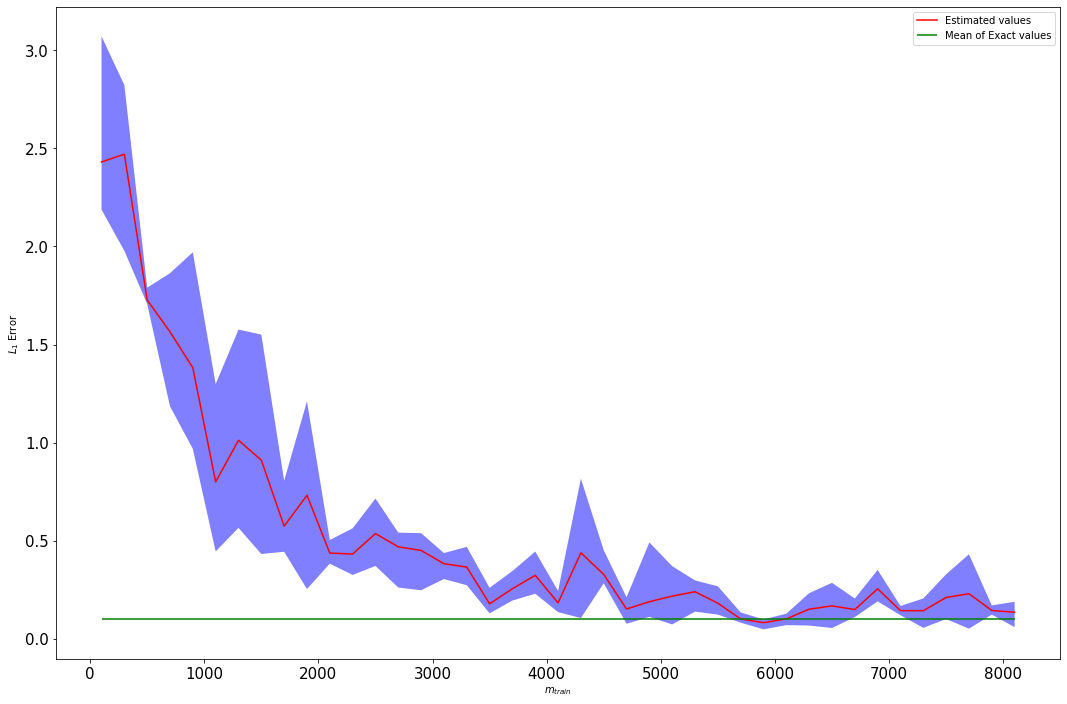

In [12]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(training_budget_values, errors.mean(axis=1), "r", label="Estimated values")
ax.hlines(error_from_mean, training_budget_values.min(), training_budget_values.max(), "g", label="Mean of Exact values")
ax.fill_between(training_budget_values, errors.min(axis=1), errors.max(axis=1), facecolor="blue", alpha=0.5)
ax.set_xlabel("$m_{train}$")
ax.set_ylabel("$L_1$ Error")
plt.legend()
plt.show()

As can be seen, the above plot matches the plots in the paper and thus shows that the method works for estimating the Data Shapley values.